In [1]:
import sys
import torch
import os 
import numpy as np
from PIL import Image, ImageOps
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from PIL import Image
sys.path.append('..')  
import scipy

from types import SimpleNamespace
from model.model import MMC  
from src.config import Config

import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


/raid/nlp/rajak/flask/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = SimpleNamespace(
    name='MMC',
    dataset='Food101',  # Adjust as per your dataset or requirement
    text_type='abstract',
    mmc='UniSMMC',
    mmc_tao=0.07,
    batch_size=32,
    lr_mm=0.001,
    min_epoch=1,
    valid_step=50,
    max_length=512,
    text_encoder='bert_base',
    image_encoder='vit_base',
    text_out=768,
    img_out=768,
    lr_mm_cls=0.001,
    mm_dropout=0.0,
    lr_text_tfm=2e-5,
    lr_img_tfm=5e-5,
    lr_img_cls=0.0001,
    lr_text_cls=5e-5,
    text_dropout=0.0,
    img_dropout=0.1,
    nplot='',
    data_dir='../datasets/',  # Ensure this path is correct in your notebook environment
    test_only=False,
    pretrained_dir='../pretrained_models',  # Adjust as necessary
    model_save_dir='Path/To/results/models',
    res_save_dir='Path/To/results/results',
    fig_save_dir='Path/To/results/imgs',
    logs_dir='Path/To/results/logs',
    local_rank=-1,
    seeds=None,
    model_path='./Path/To/results/models',
    save_model=True,
    cross_attention=False,
    text_mixup=False,
    image_mixup=False,
    image_embedding_mixup=False,
    alpha=0.2,
    multi_mixup=True,
    mixup_pct=0.33,
    lambda_mixup=0.1,
    mixup_beta=0.15,
    mixup_s_thresh=0.5,
    lr_scheduler='ReduceLROnPlateau',
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

config = Config(args)
args = config.get_config()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.local_rank == -1:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")

args.device = device
print(args.data_dir)
args.data_dir = os.path.join(args.data_dir, args.dataset)

#args.best_model_save_path = os.path.join(args.model_save_dir, f'{args.dataset}-best-{time.strftime("%Y%m%d-%H%M%S")}.pth')

../datasets/


In [3]:
print(args.data_dir)

../datasets/Food101


In [4]:
model = MMC(args)

/raid/nlp/rajak/flask/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
# model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-m3col.pth'
# model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-m3co.pth'
# model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-multisoftclip.pth'
model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-no-unimodal.pth'
# model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-mixup.pth'
model.load_state_dict(torch.load(model_path), strict=False)
model = model.to(device=args.device)

In [6]:
def get_sentence_embedding(text, model, args):
    # Assuming the model's text_encoder has already been initialized
    tokenizer = model.text_encoder.get_tokenizer()
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input['input_ids'].to(device=args.device)
    print("input ids shape: ", input_ids.shape)
    attention_mask = encoded_input['attention_mask'].to(device=args.device)
    print("attention_mask shape: ", attention_mask.shape)
    print("attention_mask: ", print(attention_mask))
    
    with torch.no_grad():
        if 'roberta' in model.text_encoder.text_encoder:
            embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
        else:
            token_type_ids = encoded_input.get('token_type_ids').to(device=args.device)
            print("token_type_ids shape: ", token_type_ids.shape)
            embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

    print("embeddings shape: ", embeddings.shape)
    embeddings = embeddings.squeeze(dim = 0)
    print("embeddings shape: ", embeddings.shape)

    # # TAKING MEAN to take final embeddings
    #final_embedding= torch.mean(embeddings, dim=0)
    # print("final embedding shape: ", final_embedding.shape)

    #Taking embedding of CLS token to get the final embedding
    final_embedding = embeddings[0, :]
    final_embedding = final_embedding / final_embedding.norm()
    print("final embedding shape: ", final_embedding.shape)

    return final_embedding


In [7]:
def get_image_embedding(patch, model, args):
    feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
    inputs = feature_extractor(images=patch, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  

    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    #print("image embeddings shape:", image_embeddings.shape)
    image_embeddings = image_embeddings.squeeze()
    #print("image embeddings shape:", image_embeddings.shape)

    # #Taking final embedding as mean embedding
    #final_embedding= torch.mean(image_embeddings, dim=0)
    # print("final embedding shape: ", final_embedding.shape)

    # Taking final embedding as cls embedding
    final_embedding = image_embeddings[0,:]
    final_embedding = final_embedding / final_embedding.norm()
    #print("final embedding shape: ", final_embedding.shape)

    return final_embedding

In [8]:
def pad_image(image, patch_size):
    width, height = image.size
    print("width: ", width, " height: ", height)
    pad_width = (patch_size - width % patch_size) % patch_size
    pad_height = (patch_size - height % patch_size) % patch_size
    padded_image = ImageOps.expand(image, (0, 0, pad_width, pad_height))
    pwidth, pheight = padded_image.size
    print("padded width: ", pwidth, " padded height: ", pheight)
    return padded_image

def get_image_patches(image, patch_size):
    patches = []
    width, height = image.size
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)
    return patches

def visualize_patches(image, patches, patch_size):
    num_patches = len(patches)
    cols = int(image.size[0] / patch_size)
    rows = int(num_patches / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, patch in enumerate(patches):
        row = i // cols
        col = i % cols
        axes[row, col].imshow(patch)
        axes[row, col].axis('off')

    plt.show()

In [9]:
def visualize_attention(image, attention_scores, patch_size):
    width, height = image.size
    heatmap = np.zeros((height // patch_size, width // patch_size))

    idx = 0
    for y in range(0, height // patch_size):
        for x in range(0, width // patch_size):
            heatmap[y, x] = attention_scores[idx]
            idx += 1

    heatmap = Image.fromarray(heatmap).resize(image.size, resample=Image.BILINEAR)
    heatmap = np.array(heatmap)

    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5, cmap='jet', interpolation='bilinear')
    #plt.colorbar()
    plt.axis('off')
    plt.show()

input ids shape:  torch.Size([1, 5])
attention_mask shape:  torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]], device='cuda:0')
attention_mask:  None
token_type_ids shape:  torch.Size([1, 5])
embeddings shape:  torch.Size([1, 5, 768])
embeddings shape:  torch.Size([5, 768])
final embedding shape:  torch.Size([768])


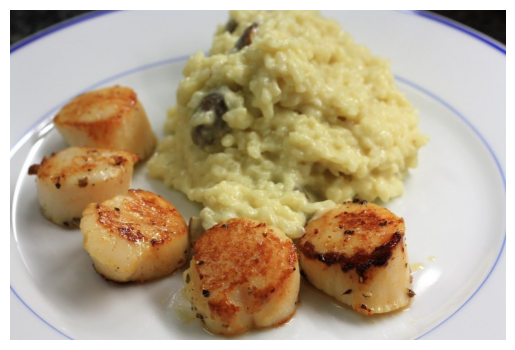

In [10]:
text_emb = get_sentence_embedding("risotto", model, args)

name = 'risotto'
number = 55
image_path = f'/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/train/{name}/{name}_{str(number)}.jpg'
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

width:  1102  height:  734
padded width:  1152  padded height:  768


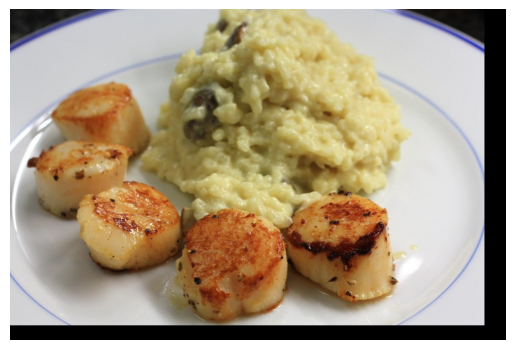

In [11]:
patch_size = 64
padded_image = pad_image(image, patch_size)
plt.imshow(padded_image)
plt.axis('off')  # Hide axes
plt.show()


In [12]:
patches = get_image_patches(padded_image, patch_size)
print(len(patches))
#visualize_patches(image, patches, patch_size)
patches_embeddings = []
attention_scores = []
for patch in tqdm(patches):
    patch_embedding = get_image_embedding(patch, model,args) 
    patches_embeddings.append(patches_embeddings)
    score = torch.dot(patch_embedding,text_emb)
    attention_scores.append(abs(score.item()))

216


100%|██████████| 216/216 [00:02<00:00, 78.06it/s] 


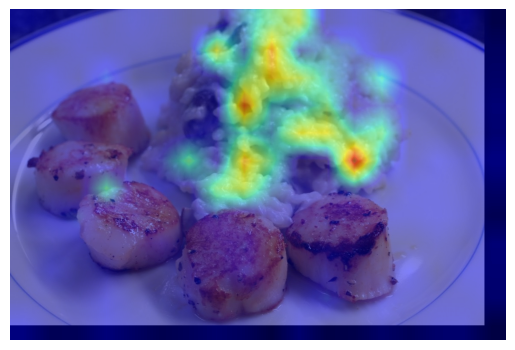

In [13]:
visualize_attention(padded_image, attention_scores, patch_size)

News24


In [14]:
# softclip_model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/n24news-best-softclip.pth'
# multimixco_model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/n24news-best-multimixco.pth'

In [15]:
# def get_sentence_embedding(text, model, args):
#     # Assuming the model's text_encoder has already been initialized
#     tokenizer = model.text_encoder.get_tokenizer()
#     encoded_input = tokenizer(text, return_tensors="pt")
#     input_ids = encoded_input['input_ids'].to(device=args.device)
#     print("input ids shape: ", input_ids.shape)
#     attention_mask = encoded_input['attention_mask'].to(device=args.device)
#     print("attention_mask shape: ", attention_mask.shape)
#     token_type_ids = encoded_input.get('token_type_ids').to(device=args.device) 
#     print("token_type_ids shape: ", token_type_ids.shape)
#     print("attention_mask: ", print(attention_mask))
    
#     with torch.no_grad():
#         if 'roberta' in model.text_encoder.text_encoder:
#             embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
#         else:
#             embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

#     print("embeddings shape: ", embeddings.shape)
#     embeddings = embeddings.squeeze(dim = 0)
#     print("embeddings shape: ", embeddings.shape)

#     # # TAKING MEAN to take final embeddings
#     # final_embedding= torch.mean(embeddings, dim=0)
#     # print("final embedding shape: ", final_embedding.shape)

#     #Taking embedding of CLS token to get the final embedding
#     final_embedding = embeddings[0, :]
#     print("final embedding shape: ", final_embedding.shape)

#     return final_embedding

In [16]:
# def get_image_embedding(image_path, model, args):
#     image = Image.open(image_path).convert('RGB')
#     feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
#     inputs = feature_extractor(images=image, return_tensors="pt")
#     pixel_values = inputs['pixel_values']

#     model.eval()
#     pixel_values = pixel_values.to(args.device)  

#     # Extract embeddings
#     with torch.no_grad():
#         image_embeddings = model.image_encoder(pixel_values)
    
#     print("image embeddings shape:", image_embeddings.shape)
#     image_embeddings = image_embeddings.squeeze()
#     print("image embeddings shape:", image_embeddings.shape)

#     # #Taking final embedding as mean embedding
#     # final_embedding= torch.mean(image_embeddings, dim=0)
#     # print("final embedding shape: ", final_embedding.shape)

#     # Taking final embedding as cls embedding
#     final_embedding = image_embeddings[0,:]
#     print("final embedding shape: ", final_embedding.shape)

#     return final_embedding

In [17]:
# def get_patch_embeddings(image, model, args):
#     feature_extractor = model.image_encoder.get_tokenizer()  
#     inputs = feature_extractor(images=image, return_tensors="pt")
#     pixel_values = inputs['pixel_values']

#     model.eval()
#     pixel_values = pixel_values.to(args.device)  

#     # Extract embeddings
#     with torch.no_grad():
#         image_embeddings = model.image_encoder(pixel_values)
    
#     print("image embeddings shape:", image_embeddings.shape)
#     return image_embeddings.squeeze()  

In [18]:
# def compute_attention_scores(patch_embeddings, word_embedding):
#     # Normalize the embeddings
#     patch_embeddings = patch_embeddings / torch.norm(patch_embeddings, dim=1, keepdim=True)
#     word_embedding = word_embedding / torch.norm(word_embedding)
    
#     attention_scores = torch.abs(torch.matmul(patch_embeddings, word_embedding.unsqueeze(-1)).squeeze(-1))
#     return attention_scores

In [19]:
# name = 'gnocchi'
# number = 225

In [20]:
# word_embedding = get_sentence_embedding(name, model, args)

In [21]:
# #image_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/train/waffles/waffles_259.jpg'
# image_path = f'/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/train/{name}/{name}_{str(number)}.jpg'
# image_embedding = get_image_embedding(image_path, model, args) 
# image = Image.open(image_path).convert('RGB')
# patch_embeddings = get_patch_embeddings(image,model,args) 
# print(patch_embeddings.shape)

In [22]:
# attention_scores = compute_attention_scores(patch_embeddings,word_embedding)
# print(attention_scores.shape)


In [23]:
# def visualize_attention_map(image_path, attention_scores, patch_size=1):
#     image = Image.open(image_path)
#     img_width, img_height = image.size

#     #attention_scores = gaussian_filter(attention_scores, sigma=1)


#     num_patches_side = int(np.sqrt(len(attention_scores) - 1))  
#     attention_scores_2d = attention_scores[1:].view(num_patches_side, num_patches_side).detach().cpu().numpy()  

#     # Create the heatmap
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(image)

#     # Overlay the heatmap
#     heatmap = ax.imshow(np.kron(attention_scores_2d, np.ones((patch_size, patch_size))),
#                         cmap='cool', alpha=0.5, extent=(0, img_width, img_height, 0), interpolation='bilinear')

#     # Add color bar
#     cbar = plt.colorbar(heatmap)
#     cbar.set_label('Attention Score')

#     plt.axis('off')
#     plt.show()

In [24]:
# visualize_attention_map(image_path, attention_scores)